# MINERIA DE DATOS 
# Carrera: Big Data
#Estudiante: Jonnathan Astudillo
#Fecha:24/04/2024

# Objetivos de la Práctica:
En la siguiente práctica se realizará el proceso de Extracción, Transformación y Carga de Datos.

En primera instancia se debe de crear la estructura de la base de datos para ello se adjunta el script de la base de datos. En mysql cuyo nombre es: Dump20240109.ssql


### 1. Importamos las librerías

Si no tiene instalado la librería mysql.connector debe de ejecutar la siguiente línea de comandos.

In [3]:
# pip install mysql.connector

In [1]:
!pip install mysql.connector

In [2]:
!pip install xlrd

In [5]:
import mysql.connector
import pandas as pd
!pip install pymysql


     -------------------------------------- 44.8/44.8 kB 556.9 kB/s eta 0:00:00


### 2. Cargamos la data

In [10]:
# Especifica la ruta de tu archivo Excel
ruta_archivo_excel = "Datos_Taxis.xls"

# Lee el archivo Excel y conviértelo a un DataFrame
df = pd.read_excel(ruta_archivo_excel)

# Muestra las primeras filas del DataFrame
df.head()


,Placa,Clase,Marca,Año de fabricación del taxi,Categoría,Tipo taxi
0,AP-000024,Taxi Aeropuerto,Toyota,1990,Automovil,Sedan
1,AP-000033,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
2,AP-000035,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
3,AP-000049,Taxi Aeropuerto,Volvo,1990,Automovil,Sedan
4,AP-000074,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan


### 3. Proceso de extracción y Carga de Datos

### 3.1. Conexión a la base de datos

Para esta sección debe de ejecutar o importar el script de la base de datos.

In [11]:
#Método para conectar a la base de datos
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="taxis"
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

In [12]:
conexion = establecer_conexion("localhost", "root", "", "taxis")
#Comprobación de la conexión
conexion.is_connected()

True

### 3.2. Eliminar los datos de la base de datos

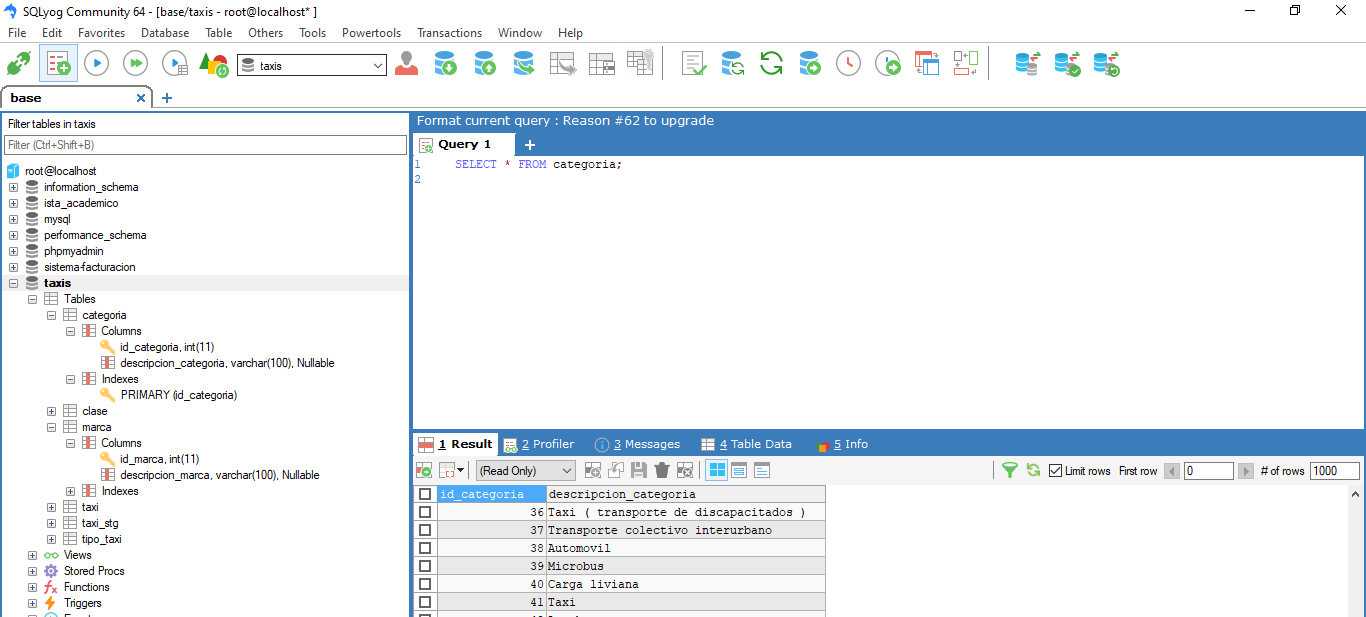

In [13]:
from IPython.display import Image
Image(filename='Captura.PNG')


In [14]:
def eliminar_datos_base(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")

        # Eliminar datos de las tablas
        delete_queries = [
            'DELETE FROM clase;',
            'DELETE FROM marca;',
            'DELETE FROM taxi;',
            'DELETE FROM categoria;',
            'DELETE FROM tipo_taxi;',
            'DELETE FROM taxi_stg;'
        ]

        for query in delete_queries:
            cursor.execute(query)

        # Reiniciar los contadores de autoincremento
        reset_auto_increment_queries = [
            'ALTER TABLE clase AUTO_INCREMENT = 1;',
            'ALTER TABLE marca AUTO_INCREMENT = 1;',
            'ALTER TABLE marca AUTO_INCREMENT = 1;',
            'ALTER TABLE categoria AUTO_INCREMENT = 1;',
            'ALTER TABLE tipo_taxi AUTO_INCREMENT = 1;',
            'ALTER TABLE taxi_stg AUTO_INCREMENT = 1;'
        ]

        for query in reset_auto_increment_queries:
            cursor.execute(query)

        # Confirmar los cambios
        conexion.commit()

        print("Base de datos limpiada exitosamente.")

    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")

    finally:
        # Reactivar las restricciones de clave externa
        cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
        cursor.close()


In [15]:
eliminar_datos_base(conexion)

Base de datos limpiada exitosamente.


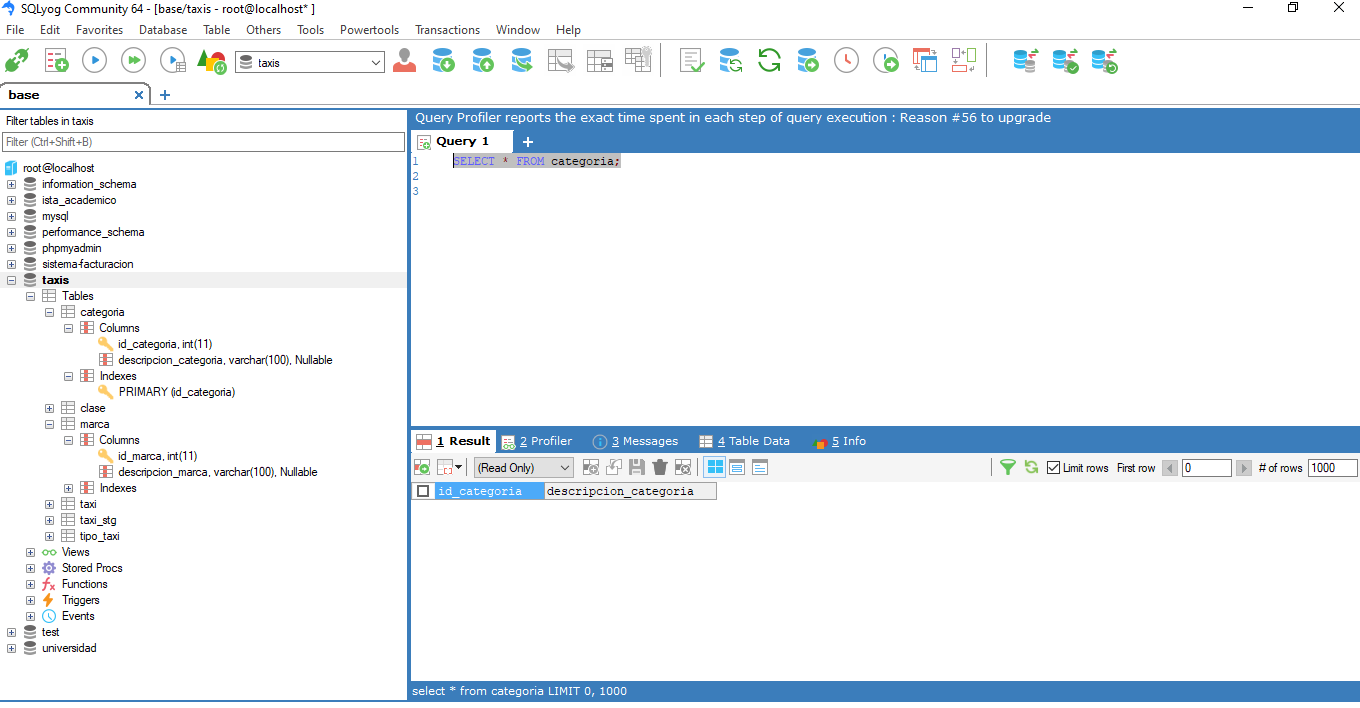

In [16]:
from IPython.display import Image
Image(filename='Cap.PNG')

### 3.3. Insertar datos a la tabla taxi

In [17]:
  
def insert_taxi_stg(conexion, df):
    cursor = conexion.cursor()

    insert_query = "INSERT INTO taxi_stg(placa,clase,marca, ano_fabricacion,categoria,tipo_taxi) VALUES (%s, %s, %s, %s, %s, %s)"

    try:
        for index, row in df.iterrows():
            taxi_data = (row['Placa'], row['Clase'], row['Marca'], row['Año de fabricación del taxi'], row['Categoría'], row['Tipo taxi'])
            cursor.execute(insert_query, taxi_data)

        conexion.commit()
        print(f"Datos insertados correctamente")

    except Exception as e:
        print(f"Error al insertar datos: {e}")

    finally:
        cursor.close()

In [18]:
insert_taxi_stg(conexion, df)

Datos insertados correctamente


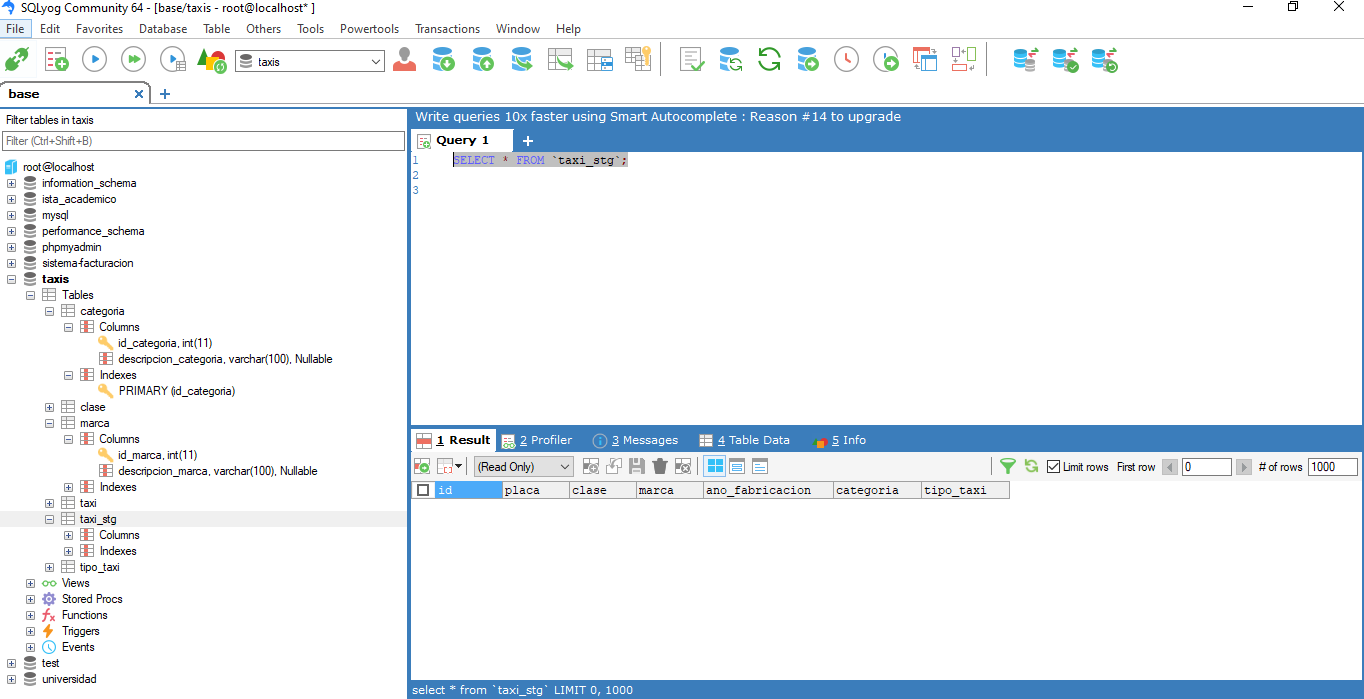

In [19]:
from IPython.display import Image
Image(filename='Ca1.PNG')


### 3.4. Limpiar datos innecesarios

In [20]:
def limpiar_datos_taxi_stg(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")

        # Eliminar datos de las tablas
        delete_queries = [
            'delete from taxi_stg where ano_fabricacion=0;',
            'delete from taxi_stg where marca like"%Marca%no%registrada%";',
            'delete from taxi_stg where categoria like"%Categoria%no%registrada%";',
            'delete from taxi_stg where tipo_taxi="Noid"'        
        ]

        for query in delete_queries:
            cursor.execute(query)

        # Confirmar los cambios
        conexion.commit()

        print("Datos tabla taxi stg limpiada exitosamente.")

    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")

    finally:
        # Reactivar las restricciones de clave externa
        cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
        cursor.close()


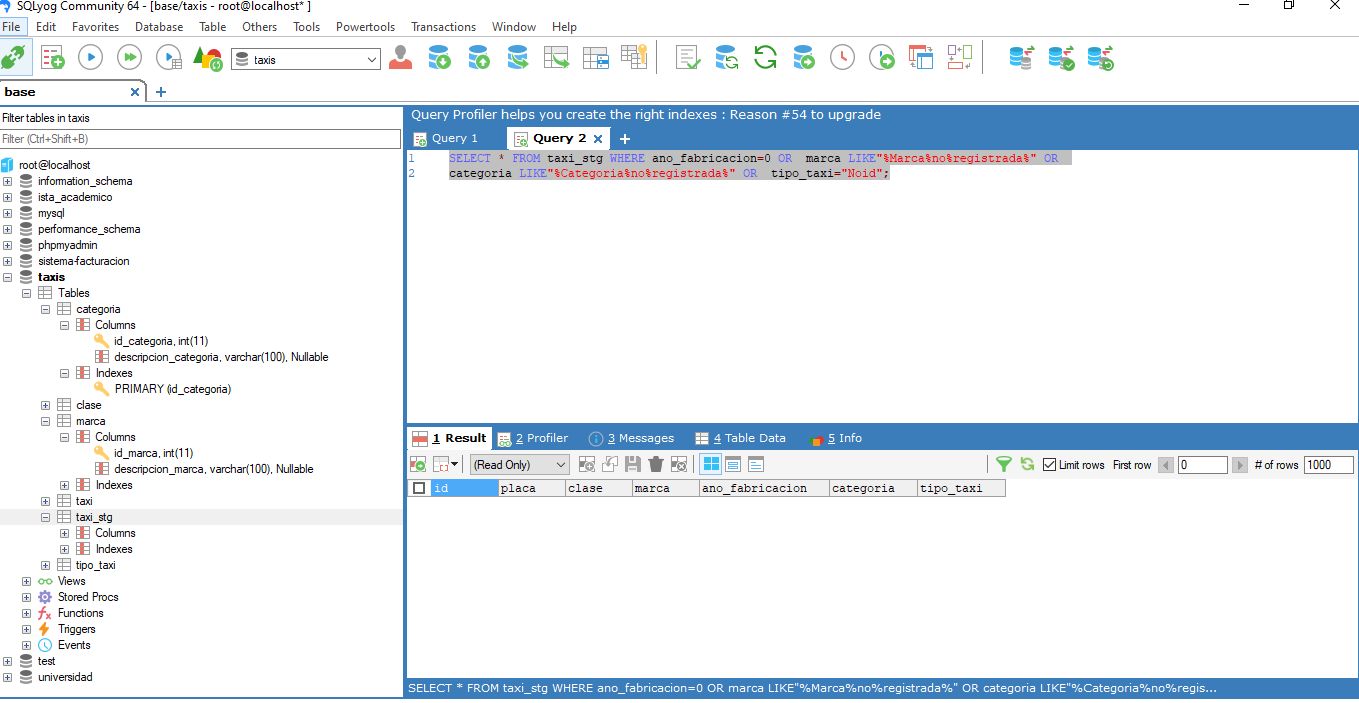

In [21]:
from IPython.display import Image
Image(filename='Ca2.PNG')

In [22]:
limpiar_datos_taxi_stg(conexion)

Datos tabla taxi stg limpiada exitosamente.


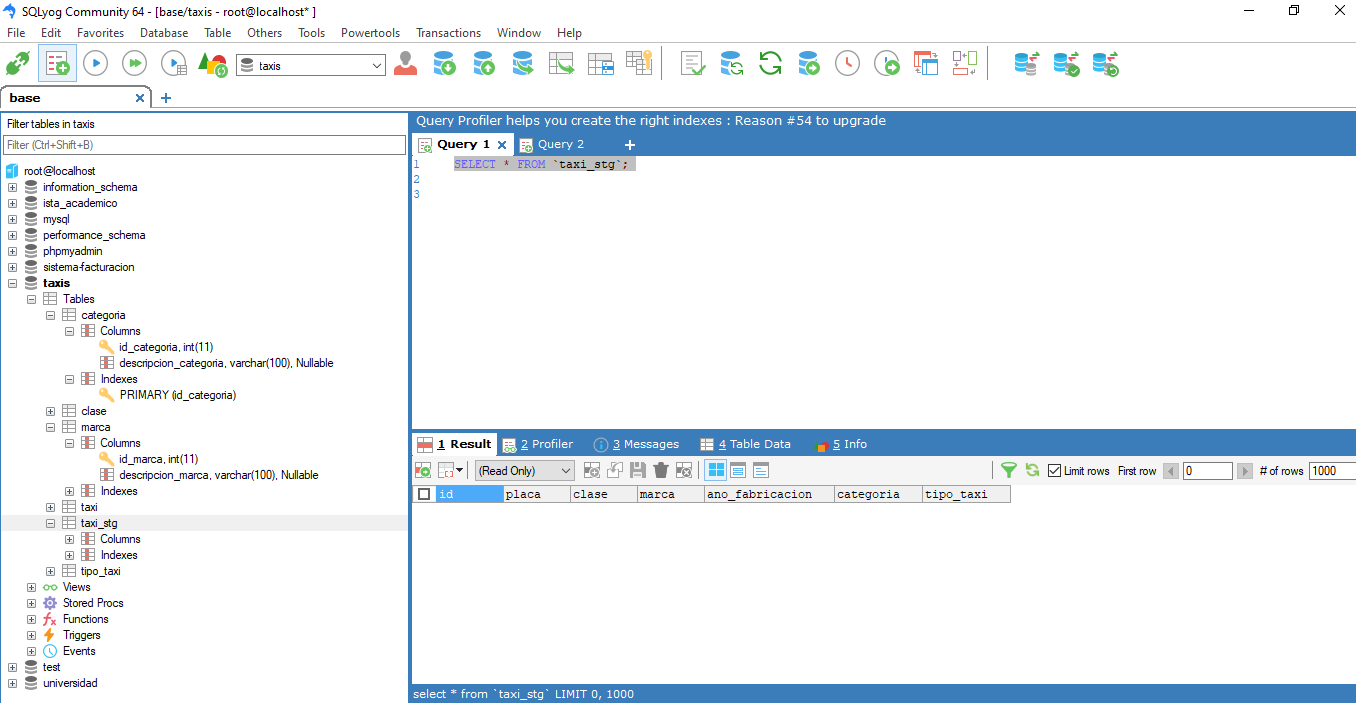

In [23]:
from IPython.display import Image
Image(filename='Ca3.PNG')

### 3.4. Obtener valores distintos y asignar a las respectivas tablas

In [24]:
 def obtener_distinct_values(conexion, column_name):
    try:
        cursor = conexion.cursor()
        select_query = f"SELECT DISTINCT({column_name}) FROM taxi_stg"
        cursor.execute(select_query)
        distinct_values = cursor.fetchall()
        print(f"Datos extraidos correctamente de: {column_name}")
        return tuple(value[0] for value in distinct_values)
    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []
    finally:
        if cursor:
            cursor.close()

In [25]:
distinct_values_categorias=obtener_distinct_values(conexion, "categoria")

Datos extraidos correctamente de: categoria


In [26]:
distinct_values_tipo_taxi=obtener_distinct_values(conexion, "tipo_taxi")

Datos extraidos correctamente de: tipo_taxi


In [27]:
distinct_values_clases=obtener_distinct_values(conexion, "clase")

Datos extraidos correctamente de: clase


In [28]:
distinct_values_marcas=obtener_distinct_values(conexion, "marca")

Datos extraidos correctamente de: marca


### 3.5. Insertar los datos extraidos en las respectivas tablas

In [29]:
def insert_distinct_values_into_table(conexion, distinct_values, table_name, column_name):
    try:
        cursor = conexion.cursor()
        insert_query = f"INSERT INTO {table_name} ({column_name}) VALUES (%s)"
        for value in distinct_values:
            cursor.execute(insert_query, (value,))

        conexion.commit()
        print(f"Datos insertados correctamente en {table_name}.")

    except Exception as e:
        print(f"Error al insertar datos en {table_name}: {e}")
    finally:
        if cursor:
            cursor.close()

insert_distinct_values_into_table(conexion, distinct_values_marcas, "marca", "descripcion_marca") 

Datos insertados correctamente en marca.


In [30]:
insert_distinct_values_into_table(conexion, distinct_values_marcas, "marca", "descripcion_marca")

Datos insertados correctamente en marca.


In [31]:
insert_distinct_values_into_table(conexion, distinct_values_clases, "clase", "descripcion_clase")

Datos insertados correctamente en clase.


In [32]:
insert_distinct_values_into_table(conexion, distinct_values_categorias, "categoria", "descripcion_categoria")

Datos insertados correctamente en categoria.


In [33]:
insert_distinct_values_into_table(conexion, distinct_values_tipo_taxi, "tipo_taxi", "descripcion_tipo_taxi")

Datos insertados correctamente en tipo_taxi.


### 3.6. Obtener los valores relacionados con su respectivo ID

In [34]:
def obtener_valores_taxi(conexion):
    try:
        cursor = conexion.cursor()
        select_query = '''
        SELECT taxi_stg.placa, clase.id_clase, marca.id_marca, taxi_stg.ano_fabricacion, categoria.id_categoria, tipo_taxi.id_tipo_taxi 
        FROM taxi_stg
        INNER JOIN clase ON taxi_stg.clase = clase.descripcion_clase
        INNER JOIN marca ON taxi_stg.marca = marca.descripcion_marca
        INNER JOIN categoria ON taxi_stg.categoria = categoria.descripcion_categoria
        INNER JOIN tipo_taxi ON taxi_stg.tipo_taxi = tipo_taxi.descripcion_tipo_taxi;
        '''
        cursor.execute(select_query)
        values = cursor.fetchall()
        cursor.close()  # Cierra el cursor después de obtener los valores
        return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []

In [35]:
valores=obtener_valores_taxi(conexion)
valores

(('AP-000024', 1, 1, 1990, 1, 1),
 ('AP-000024', 1, 47, 1990, 1, 1),
 ('AP-000033', 1, 2, 1990, 1, 1),
 ('AP-000033', 1, 48, 1990, 1, 1),
 ('AP-000035', 1, 2, 1990, 1, 1),
 ('AP-000035', 1, 48, 1990, 1, 1),
 ('AP-000049', 1, 3, 1990, 1, 1),
 ('AP-000049', 1, 49, 1990, 1, 1),
 ('AP-000074', 1, 2, 1990, 1, 1),
 ('AP-000074', 1, 48, 1990, 1, 1),
 ('AP-000119', 1, 1, 1987, 1, 1),
 ('AP-000119', 1, 47, 1987, 1, 1),
 ('AP-000136', 1, 2, 1990, 1, 1),
 ('AP-000136', 1, 48, 1990, 1, 1),
 ('AP-000145', 1, 1, 1990, 1, 1),
 ('AP-000145', 1, 47, 1990, 1, 1),
 ('AP-000201', 1, 1, 1990, 1, 1),
 ('AP-000201', 1, 47, 1990, 1, 1),
 ('AP-000216', 1, 1, 1990, 1, 1),
 ('AP-000216', 1, 47, 1990, 1, 1),
 ('AP-000239', 1, 2, 1990, 1, 1),
 ('AP-000239', 1, 48, 1990, 1, 1),
 ('TAP-000002', 1, 1, 2014, 1, 1),
 ('TAP-000002', 1, 47, 2014, 1, 1),
 ('TAP-000003', 1, 1, 2014, 2, 2),
 ('TAP-000003', 1, 47, 2014, 2, 2),
 ('TAP-000004', 1, 1, 2014, 1, 1),
 ('TAP-000004', 1, 47, 2014, 1, 1),
 ('TAP-000005', 1, 2, 2014, 

### 3.7. Insertar los valores en la tabla Taxi

In [36]:
def insert_tabla_taxi(conexion, values):
    try:
        cursor = conexion.cursor()
        insert_query = "INSERT INTO taxi (placa, id_clase, id_marca, ano_fabricacion, id_categoria, id_tipo_taxi) VALUES (%s, %s, %s, %s, %s, %s)"

        for value in values:
            cursor.execute(insert_query, value)

        conexion.commit()
        print("Datos insertados correctamente.")

    except Exception as e:
        print(f"Error al insertar datos: {e}")
    
    finally:
        if cursor:
            cursor.close()

def cerrar_conexion(conexion):
    if conexion:
        conexion.close()


In [37]:
insert_tabla_taxi(conexion, valores)

Datos insertados correctamente.


Comprobar en la base de datos que se hayan insertado los datos correctamente y responder a las siguientes preguntas:

### 1. Diseño de la Base de Datos:

¿Cuál es la estructura de la base de datos utilizada en la práctica?

la base datos llamado taxis, cuanta de 6 tablas llamadas categorias,marca,taxis,clase,taxi_stg,tipo_taxi


¿Cómo están relacionadas las tablas entre sí?
La tabla categorías define las categorías generales de los taxis.
La tabla marca define las marcas de los automóviles utilizados como taxis.
La tabla taxis almacena la información principal sobre cada taxi individual, incluyendo su categoría, marca, clase, tipo y estado.
La tabla clase define las diferentes clases de servicio ofrecidas por los taxis.
La tabla taxi_stg podría usarse como tabla temporal para almacenar datos nuevos o modificados.


### 2. Proceso de Extracción y Limpieza:

¿Cómo se realiza la extracción de datos desde el archivo Excel hacia un DataFrame de pandas?

La extracción de datos desde un archivo Excel hacia un DataFrame de Pandas en Python se realiza utilizando la función read_excel() del módulo pandas. Esta función permite leer los datos de un archivo Excel y almacenarlos en un DataFrame de Pandas.

¿Qué criterios se utilizaron para limpiar los datos innecesarios en la tabla taxi_stg?

Identificar problemas de calidad de datos:

Duplicados: busque registros duplicados que representen el mismo registro.
Valores faltantes: identifique y maneje los valores faltantes de manera consistente, ya sea eliminando registros incompletos

### 3.Inserción de Datos:

¿Cuáles son los pasos específicos para insertar datos en la tabla taxi_stg desde el DataFrame de pandas?


1. Establecer la conexión con la base de datos

2. Preparar los datos para su inserción

3. Ejecutar la inserción de datos:



### 4.Obtención y Asignación de Valores Distintos:

¿Cómo se obtienen y asignan los valores distintos de las columnas categoria, tipo_taxi, clase y marca a sus respectivas tablas?


1. Conectarse a la base de datos:

2. Consultar valores distintos:

3. Recorrer y as4. Cerrar la conexión:

4. Cerrar la conexión:


### 5.Relación de Datos y Carga Final:

¿Cómo se establecen las relaciones entre las tablas taxi_stg, clase, marca, categoria, tipo_taxi y taxi?

Identificar claves primarias

Crear claves foráneas en la tabla de taxis

Hacer cumplir la integridad referencial

¿Cuál es el proceso final para cargar los datos en la tabla taxi?
debemso crear la conexion y insertar los datos de la tabla 



# PARTE 2. LECTURA DE DATOS DESDE LA BASE DE DATOS Y VISUALIZACIÓN DE DATOS
### Objetivos:
##### Extraer los datos desde la base de Datos
##### Análisis Exploratorio Efectivo: Enseñar técnicas fundamentales de análisis exploratorio de datos, incluida la identificación y manejo de valores faltantes, así como la exploración de estadísticas descriptivas, para obtener una comprensión inicial de los conjuntos de datos.
##### Visualización Impactante: Introducir conceptos clave de visualización de datos utilizando Matplotlib y Seaborn, y explorar la integración de "PowerClient - Quick Report" para generar visualizaciones impactantes que resalten patrones y tendencias de manera clara y efectiva.

### 1: Importación de librerías

In [1]:
# pip install mysql.connector

In [ ]:
import pandas as pd
import mysql.connector
import pandas as pd

### 2: Cargar los datos

In [ ]:
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

            
def obtener_valores_taxi(conexion):
    try:
        with conexion.cursor() as cursor:
            select_query = '''
            SELECT * from taxi_stg;
            '''
            cursor.execute(select_query)
            values = cursor.fetchall()
            return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []

            
def cerrar_conexion(conexion):
    if conexion:
        conexion.close()


In [ ]:
conexion = establecer_conexion("localhost", "root", "", "taxis_prueba")
conexion.is_connected()

True

In [ ]:
datos_taxi=obtener_valores_taxi(conexion)

In [6]:
# Convertir la tupla en un DataFrame
columnas = ['Id','Placa', 'Clase', 'Marca', 'Año', 'Categoría', 'Tipo taxi']
df = pd.DataFrame(datos_taxi, columns=columnas)

In [7]:
df

,Id,Placa,Clase,Marca,Año,Categoría,Tipo taxi
0,1,AP-000024,Taxi Aeropuerto,Toyota,1990,Automovil,Sedan
1,2,AP-000033,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
2,3,AP-000035,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
3,4,AP-000049,Taxi Aeropuerto,Volvo,1990,Automovil,Sedan
4,5,AP-000074,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
...,...,...,...,...,...,...,...
23405,23406,TSJ-007129,Taxi San José,Peugeot,2015,Automovil,Adaptado
23406,23407,TSJ-007135,Taxi San José,Peugeot,2015,Automovil,Adaptado
23407,23408,TSJ-007136,Taxi San José,Citroen,2014,Automovil,Sedan
23408,23409,TSJ-007146,Taxi San José,Peugeot,2015,Automovil,Adaptado


In [18]:
# Eliminar la columna 'Id'
df = df.drop('Id', axis=1)

### 3: Librería Y-Data Profiling
https://docs.profiling.ydata.ai/4.6/ 

In [8]:
from ydata_profiling import ProfileReport

In [9]:
profile=ProfileReport(df,title="Análisis de datos")


In [10]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 4: Librería sweetviz

In [11]:
import sweetviz as sv

In [12]:
advert_report=sv.analyze([df,"Reporte DATOS"])

                                             |          | [  0%]   00:00 -> (? left)

In [13]:
advert_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


###  5: Librería Power Bi

In [14]:
#pip install powerbiclient

In [15]:
from powerbiclient import QuickVisualize, get_dataset_config

In [16]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI
from powerbiclient.authentication import DeviceCodeLoginAuthentication
    
# Initiate device authentication
device_auth = DeviceCodeLoginAuthentication()

Performing device flow authentication. Please follow the instructions below.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FAK5J5UWA to authenticate.

Device flow authentication successfully completed.
You are now logged in .

The result should be passed only to trusted code in your notebook.


In [19]:
# Create a Power BI report from your data
PBI_visualize = QuickVisualize(get_dataset_config(df), auth=device_auth)

# Render new report
PBI_visualize

QuickVisualize()

## 6: Preguntas

### 6.1. Extracción de Datos:

Describe el proceso de extracción de datos desde la base de datos MySQL. 

¿Qué consulta SQL se utiliza para obtener los datos de la tabla taxi_stg?

### 6.2. Visualización con Y-Data Profiling:

Basándote en el informe de Y-Data Profiling, ¿qué información relevante se destaca sobre el conjunto de datos? ¿Cómo interpretarías los resultados del análisis?

### 6.3. Visualización con Sweetviz:

¿Cuáles son las principales visualizaciones proporcionadas por Sweetviz? ¿Puedes identificar patrones o tendencias interesantes en el conjunto de datos?

### 6.4. Visualización con Power BI:

Explica el proceso de autenticación utilizado para conectar Python a Power BI. ¿Cómo se genera y visualiza el informe en Power BI utilizando el conjunto de datos?

### 6.5. Comparación de Librerías:

¿Cuáles son las diferencias clave entre Y-Data Profiling, Sweetviz y Power BI en términos de funcionalidad y visualización? ¿En qué situaciones específicas podrías preferir una sobre la otra?

### 6.6. Ejercicio de extracción de la tabla taxi con sus relaciones:

Realiza la exportación de los datos de la tabla taxi y sus relaciones y modela el dataframe similar al dado.

